# Web Data Scraping

[Spring 2021 ITSS Mini-Course](https://www.colorado.edu/cartss/programs/interdisciplinary-training-social-sciences-itss/mini-course-web-data-scraping) — ARSC 5040  
[Brian C. Keegan, Ph.D.](http://brianckeegan.com/)  
[Assistant Professor, Department of Information Science](https://www.colorado.edu/cmci/people/information-science/brian-c-keegan)  
University of Colorado Boulder  

Copyright and distributed under an [MIT License](https://opensource.org/licenses/MIT)

## Class outline

* **Week 1**: Introduction to Jupyter, browser console, structured data, ethical considerations
* **Week 2**: Scraping HTML with `requests` and `BeautifulSoup`
* **Week 3**: Scraping web data with Selenium
* **Week 4**: Scraping an API with `requests` and `json`, Wikipedia and Reddit
* **Week 5**: Scraping data from Twitter

## Acknowledgements

This course will draw on resources built by myself and [Allison Morgan](https://allisonmorgan.github.io/) for the [2018 Summer Institute for Computational Social Science](https://github.com/allisonmorgan/sicss_boulder), which were in turn derived from [other resources](https://github.com/simonmunzert/web-scraping-with-r-extended-edition) developed by [Simon Munzert](http://simonmunzert.github.io/) and [Chris Bail](http://www.chrisbail.net/). 

Thank you also to Professor [Terra KcKinnish](https://www.colorado.edu/economics/people/faculty/terra-mckinnish) for coordinating the ITSS seminars.

This notebook is adapted from excellent notebooks in Dr. [Cody Buntain](http://cody.bunta.in/)'s seminar on [Social Media and Crisis Informatics](http://cody.bunta.in/teaching/2018_winter_umd_inst728e/) as well as the [PRAW documentation](https://praw.readthedocs.io/en/latest/).

## Class 4 goals

* Sharing accomplishments and challenges with last week's material
* Accessing an API with `requests`
* Retrieiving historical web data from the Internet Archive
* Why you don't want to write a parser for Wikipedia's data
* Fundamentals of retrieving information from Wikipedia's API
* EDA with data from Wikipedia's API
* Reddit's API, time permitting

We'll need a few common libraries for all these examples.

In [51]:
# Lets us talk to other servers on the web
import requests

# APIs spit out data in JSON
import json

# Use time sleep to slow things down
from time import sleep

# Use BeautifulSoup to parse some HTML
from bs4 import BeautifulSoup

# Handling dates and times
from datetime import datetime

# DataFrames!
import pandas as pd
import numpy as np

# Data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

## Scraping the Internet Archive's Wayback Machine

Now we'll leave some of the ethically-fraught methods of web scraping behind. The Internet Archive maintains the "[Wayback Machine](https://www.archive.org/web/)" where old versions of websites are stored. Some of my favorites:

* [CNN in June 2000](https://web.archive.org/web/20000815052826/http://www.cnn.com/)
* [Facebook in August 2004](https://web.archive.org/web/20040817020419/http://www.facebook.com/)
* [Apple in April 1997](https://web.archive.org/web/19970404064444/http://www.apple.com:80/)

In these URLs above, there is a numeric identifier corresponding to the timestamp when the image of the website was captured. How do we know when the Wayback Machine archived a webpage? There's a free and open API!

### Using the Wayback Machine API

The simplest API request we can make asks for the most recent snapshot of a webpage archived by the Wayback Machine.

In [2]:
wb_url = 'http://archive.org/wayback/available?url=facebook.com'

wb_response = requests.get(wb_url)

wb_response.json()

{'url': 'facebook.com',
 'archived_snapshots': {'closest': {'available': True,
   'url': 'http://web.archive.org/web/20210319123430/https://www.facebook.com/',
   'status': '200',
   'timestamp': '20210319123430'}}}

This response tells us the timestamp and location of this snapshot, which we could then go retrieve and parse.

In [10]:
wb_response.json()['archived_snapshots']['closest']['url']

'http://web.archive.org/web/20210319123430/https://www.facebook.com/'

In [11]:
wb_response_json = wb_response.json()

recent_fb_wb_url = wb_response_json['archived_snapshots']['closest']['url']

recent_fb_wb_response = requests.get(recent_fb_wb_url)

Get the raw text out, soupify, and look for links. For some reason all the links in this snapshot are in German.

In [12]:
recent_fb_wb_raw = recent_fb_wb_response.text

recent_fb_wb_soup = BeautifulSoup(recent_fb_wb_raw)

[link.text for link in recent_fb_wb_soup.find_all('a')]

['Sections of this page',
 'Accessibility Help',
 '',
 'Forgot Password?',
 'Create New Account',
 'Create a Page',
 'Español',
 'Français (France)',
 '中文(简体)',
 'العربية',
 'Português (Brasil)',
 '한국어',
 'Italiano',
 'Deutsch',
 'हिन्दी',
 '日本語',
 '',
 'Sign Up',
 'Log In',
 'Messenger',
 'Facebook Lite',
 ' Watch ',
 'People',
 'Pages',
 'Page Categories',
 'Places',
 'Games',
 'Locations',
 'Marketplace',
 'Facebook Pay',
 'Groups',
 'Jobs',
 'Oculus',
 'Portal',
 'Instagram',
 'Local',
 'Fundraisers',
 'Services',
 'Voting Information Center',
 'About',
 'Create Ad',
 'Create Page',
 'Developers',
 'Careers',
 'Privacy',
 'Cookies',
 'Ad Choices',
 'Terms',
 'Help',
 'Settings',
 'Activity Log']

We can also ask for the most recent snapshot of a webpage around a specific date. Let's ask the Wayback Machine for a snapshot of Facebook around February 1, 2008.

In [13]:
wb_url = 'http://archive.org/wayback/available?url=facebook.com&timestamp=20080201'

wb_response = requests.get(wb_url)

wb_response_json = wb_response.json()

wb_response_json

{'archived_snapshots': {'closest': {'timestamp': '20080130203428',
   'available': True,
   'status': '200',
   'url': 'http://web.archive.org/web/20080130203428/http://www.facebook.com/'}},
 'timestamp': '20080201',
 'url': 'facebook.com'}

Note that this is a relatively deep JSON object we have to navigate into to access information like the Wayback URL or the timestamp of the snapshot. The closest snapshot to February 1, 2008 was January 30, 2008. We use the [`datetime.strptime`](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior) function to turn this numeric string that we recognize as a timestamp into a datetime object.

In [14]:
wb_response_json['archived_snapshots']['closest']['timestamp']

'20080130203428'

In [26]:
datetime.strptime('Sunday 13 February 1984','%A %d %B %Y') - datetime.today()

datetime.timedelta(days=-13550, seconds=52120, microseconds=172040)

In [15]:
print(datetime.strptime('20080130203428','%Y%m%d%H%M%S'))

2008-01-30 20:34:28


As before, we could scrape out the links on this 2008 version of the page.

In [27]:
# Find the old URL
fb_wb_url = wb_response_json['archived_snapshots']['closest']['url']

# Go get the archived snapshot from the Wayback Machine
fb_wb_response = requests.get(fb_wb_url)

# Get the text from the response
fb_wb_raw = fb_wb_response.text

# Soup-ify
fb_wb_soup = BeautifulSoup(fb_wb_raw)

# Make a list of the text of the links
[link.text for link in fb_wb_soup.find_all('a')]

[' ',
 'Forgot Password?',
 'Tour',
 '',
 'Login',
 'Sign Up',
 'upload photos',
 'publish notes',
 'latest news',
 'privacy settings',
 'join a network',
 'Find your friends',
 'More Search Options »',
 'Advertisers',
 'Businesses',
 'Developers',
 'About Facebook',
 'Terms',
 'Privacy',
 'Help']

### Scraping historical web pages

A current project I am working on is exploring how social media platforms' terms of service have evolved over time. Let's start with Facebook's terms of service and privacy policy.

In [43]:
fb_tos = 'http://www.facebook.com/terms.php'
fb_pp = 'http://www.facebook.com/policy.php'

We will take advantage of the [`date_range`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html) fuction in `pandas` to generate a range of dates between January 2005 and January 2019.

In [36]:
dates_list = pd.date_range(start='2005-01-01',end='2021-03-01',freq='MS')
dates_list

DatetimeIndex(['2005-01-01', '2005-02-01', '2005-03-01', '2005-04-01',
               '2005-05-01', '2005-06-01', '2005-07-01', '2005-08-01',
               '2005-09-01', '2005-10-01',
               ...
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
               '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01',
               '2021-02-01', '2021-03-01'],
              dtype='datetime64[ns]', length=195, freq='MS')

We'll use [`datetime.strftime`](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior) (the inverse of `strptime`) to make these date objects into specifically-formatted strings that we can format into a URL.

In [39]:
dates_list[0]

Timestamp('2005-01-01 00:00:00', freq='MS')

In [41]:
# Take the first datetime object and turn it into a string
datetime.strftime(dates_list[0],'%Y%m%d')

'20050101'

Use string formatting to put the `fb_tos` URL and formatted timestamp into a request to the Wayback Machine.

In [44]:
date_str = datetime.strftime(dates_list[0],'%Y%m%d')

wb_api_url = 'https://archive.org/wayback/available?url={0}&timestamp={1}'
wb_api_url_formatted = wb_api_url.format(fb_tos,date_str)

print(wb_api_url_formatted)

https://archive.org/wayback/available?url=http://www.facebook.com/terms.php&timestamp=20050101


Make the request to the Wayback Machine to get the URL and timestamp of the Wayback Machine's closest snapshot of Facebook's Terms of Service before January 31, 2005.

In [45]:
wb_api_response = requests.get(wb_api_url_formatted)

wb_api_response.json()

{'url': 'http://www.facebook.com/terms.php',
 'archived_snapshots': {'closest': {'available': True,
   'url': 'http://web.archive.org/web/20051126052914/http://www.facebook.com:80/terms.php',
   'status': '200',
   'timestamp': '20051126052914'}},
 'timestamp': '20050101'}

Parse the markup of this old version.

In [47]:
# Find the old URL
wb_fb_old_url = wb_api_response.json()['archived_snapshots']['closest']['url']

# Go get the archived snapshot from the Wayback Machine
wb_fb_raw = requests.get(wb_fb_old_url).text

# Soup-ify
wb_fb_soup = BeautifulSoup(wb_fb_raw)

# Find the content element and get the text out
wb_fb_terms_str = wb_fb_soup.find('div',{'id':'content'}).text.strip()

# Inspect
print(wb_fb_terms_str)

IntroductionWelcome to the Facebook, an online directory that connects people through networks of academic and geographic centers. The Facebook service is operated by the Facebook network ("Facebook"). By using the Facebook web site (the "Web site") you signify that you have read, understand and agree to be bound by these Terms of Use (this "Agreement"). We reserve the right, at our sole discretion, to change, modify, add, or delete portions of these Terms of Use at any time without further notice. If we do this, we will post the changes to these Terms of Use on this page and will indicate at the top of this page the Terms of Use's effective date. Your continued use of the Web site after any such changes constitutes your acceptance of the new Terms of Use.  If you do not agree to abide by these or any future Terms of Use, please do not use or access Web site.  It is your responsibility to regularly review these Terms of Use.EligibilityYou must be thirteen years of age or older to regis

We could use a really dumb stemmer, [`.split()`](https://docs.python.org/3.7/library/stdtypes.html#str.split) to count the number of words in these terms.

In [48]:
len(wb_fb_terms_str.split())

1901

Write a loop to find a snapshot of Facebook's ToS each month in our `dates_list`. 

In [49]:
def get_urls(url_str,start_date='2005-01-01',end_date='2021-03-01',freq='M'):
    
    # Make the list of dates
    date_l = pd.date_range(start_date,end_date,freq=freq)
    
    # Create an empty container to store our data
    urls = dict()

    # For each date in the list of dates
    for date in date_l:
        
        sleep(1)
        
        print(date)
        
        # Turn the date object back into a string
        date_str = datetime.strftime(date,'%Y%m%d%H%M%S')
        
        # Define the API URL request to the Wayback machine
        wb_api_url = 'http://archive.org/wayback/available?url={0}&timestamp={1}'
        
        # Format the API URL with the URL of the website and the closest datetime
        wb_api_request = wb_api_url.format(url_str,date_str)
        
        # Make the request
        r = requests.get(wb_api_request).json()

        # Check if the returned request has all the right parts (this is probably overkill)
        if 'archived_snapshots' in r.keys():
            if 'closest' in r['archived_snapshots'].keys():
                if 'url' in r['archived_snapshots']['closest'].keys():
                    
                    # If it does have all the right parts, get the URL
                    _url = r['archived_snapshots']['closest']['url']
                    
                    # Get the timestamp
                    _timestamp = r['archived_snapshots']['closest']['timestamp']
                    
                    # Save to our URL dictionary with the timestamp of the snapshot as key, the url as value
                    urls[_timestamp] = _url
    return urls

Run our function to make a dictionary of keys returning the Wayback Machine URLs for each month's version of the terms of service. We'll write a loop to get the Terms for each snapshot and count the words. 

This will take a few minutes. 

I've coverted the code block into a "Raw" cell to prevent accidental execution. You can always turn it into a "Code" cell if you really want to run it.

In [50]:
# Get the list of timestamps and URLs for each monthly version of the Terms of Service
fb_terms_d = get_urls('https://www.facebook.com/terms.php',start_date='2015-01-01')

# Create an empty container to store our data
fb_terms_wordcount = {}

# Loop through the fb_terms_d dictionary
for timestamp,url in fb_terms_d.items():

    # Get the raw HTML from the Wayback Machine
    raw = requests.get(url).text
    
    # Soup-ify
    soup = BeautifulSoup(raw)
    
    # Find the content of the TOS
    content = soup.find('div',{'id':'content'}).text.strip()
    
    # Split the content into words, count the number of words, save to the container
    fb_terms_wordcount[timestamp] = len(content.split())
    
# Write to disk
with open('facebook_tos_archive.json','w') as f:
    json.dump(fb_terms_wordcount,f)

ConnectionError: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))

To avoid having everyone hit the Internet Archive server with the same requests, you can also load this file with the same data.

In [52]:
with open('facebook_tos_archive.json','r') as f:
    fb_terms_wordcount2 = json.load(f)

In [53]:
fb_terms_wordcount2

{'20051126052914': 1901,
 '20051129171348': 1901,
 '20051231025628': 1899,
 '20060128015901': 1899,
 '20060301120239': 2336,
 '20060330142650': 2336,
 '20060429104537': 2336,
 '20060527140603': 2326,
 '20060629010835': 2326,
 '20060813170103': 2326,
 '20060903044150': 2326,
 '20061007070704': 2326,
 '20061031142243': 4650,
 '20061123124528': 4650,
 '20061230091603': 4686,
 '20070202024540': 4686,
 '20070210022156': 4686,
 '20070630042627': 6062,
 '20070830163157': 6062,
 '20071012215843': 6062,
 '20071219210353': 6313,
 '20080102211804': 6313,
 '20080206193243': 6312,
 '20080227210709': 6333,
 '20080409184248': 6474,
 '20080512032755': 6368,
 '20080719132810': 6415,
 '20080730222347': 6415,
 '20080831212309': 7017,
 '20080911181120': 6415,
 '20081029201831': 6801,
 '20081120093758': 6801,
 '20090114191906': 6801,
 '20090204235420': 3615,
 '20090303034440': 6801,
 '20090315200712': 6801,
 '20090430210458': 6799,
 '20090603065116': 3173,
 '20090701003054': 3173,
 '20090731004801': 3173,


Visualize the changes in the size of Facebook's Terms of Service over time.

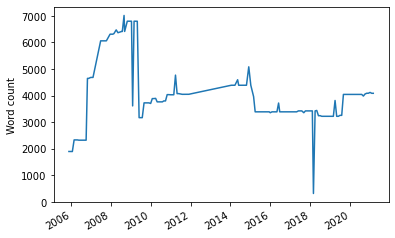

In [54]:
# Turn the dictionary into a pandas Series
fb_terms_s = pd.Series(fb_terms_wordcount2)

# Conver the index to datetime objects
fb_terms_s.index = pd.to_datetime(fb_terms_s.index)

# Plot
ax = fb_terms_s.plot()

# Make the x-tick labels less weird
# ax.set_xticklabels(range(2004,2021,2),rotation=0,horizontalalignment='center')

# Always label your axes
ax.set_ylabel('Word count');

## Scraping Wikipedia

Consider the Wikipedia page for [George H.W. Bush](https://en.wikipedia.org/wiki/George_H._W._Bush). This seems like a relatively straightforward webpage to scrape out the hyperlinks to other articles or to compare the content to other presidential biographies. However, Wikipedia also preserves the [history of every revision made to this article](https://en.wikipedia.org/w/index.php?title=George_H._W._Bush&action=history) going back to the first (available) revisions in 2001, like [this](https://en.wikipedia.org/w/index.php?title=George_H._W._Bush&oldid=345784898). Thinking back to the Oscars example, it seems promising to find the "oldid" values and visit each revision's webpage to parse the content out. However, Wikipedia will give you much of this revision history data for free through its [application programming interface](http://en.wikipedia.org/w/api.php) (API).

### Current content
We can use `requests` to get the current HTML markup of an article from the API, for example.

In [56]:
# Where the API server lives
query_url = "https://en.wikipedia.org/w/api.php"

# An empty dictionary to store our query parameters
query_params = {}

# We want to parse the content of a page
query_params['action'] = 'parse'

# Which page?
query_params['page'] = 'George H. W. Bush'

# We want the text
query_params['prop'] = 'text'

# Ignore the edit buttons and table of contents
query_params['disableeditsection'] = 1
query_params['disabletoc'] = 1

# Get the results back as JSON
query_params['format'] = 'json'

# Format the data in an easier-to-parse option
query_params['formatversion'] = 2

We have only set up our request to the API, but not sent it or received the data back.

In [57]:
json_response = requests.get(url = query_url, params = query_params).json()

In [58]:
json_response

{'parse': {'title': 'George H. W. Bush',
  'pageid': 11955,
  'text': '<div class="mw-parser-output"><div class="shortdescription nomobile noexcerpt noprint searchaux" style="display:none">41st president of the United States</div>\n<div role="note" class="hatnote navigation-not-searchable">This article is about the 41st president of the United States. For his son, the 43rd president, see <a href="/wiki/George_W._Bush" title="George W. Bush">George W. Bush</a>. For other people, see <a href="/wiki/George_Bush_(disambiguation)" class="mw-redirect mw-disambig" title="George Bush (disambiguation)">George Bush (disambiguation)</a>.</div>\n<div role="note" class="hatnote navigation-not-searchable">"H. W." redirects here. For other uses, see <a href="/wiki/HW_(disambiguation)" class="mw-redirect mw-disambig" title="HW (disambiguation)">HW (disambiguation)</a>.</div>\n<p class="mw-empty-elt">\n\n\n</p>\n<table class="infobox vcard" style="width:22em"><tbody><tr><th colspan="2" style="text-alig

What's waiting inside? A dictionary of dictionaries. The inner dictionary has keys for the title of the page we requested ("George H. W. Bush"), the pageid (a numeric identifier), and the text of the article.

In [59]:
json_response['parse'].keys()

dict_keys(['title', 'pageid', 'text'])

We could count the number of links in the article.

In [60]:
ghwb_soup = BeautifulSoup(json_response['parse']['text'])

ghwb_soup.find_all('a')[:5]

[<a href="/wiki/George_W._Bush" title="George W. Bush">George W. Bush</a>,
 <a class="mw-redirect mw-disambig" href="/wiki/George_Bush_(disambiguation)" title="George Bush (disambiguation)">George Bush (disambiguation)</a>,
 <a class="mw-redirect mw-disambig" href="/wiki/HW_(disambiguation)" title="HW (disambiguation)">HW (disambiguation)</a>,
 <a class="image" href="/wiki/File:George_H._W._Bush_presidential_portrait_(cropped).jpg" title="George H. W. Bush's presidential portrait, circa 1989"><img alt="George H. W. Bush's presidential portrait, circa 1989" data-file-height="2100" data-file-width="1600" decoding="async" height="289" src="//upload.wikimedia.org/wikipedia/commons/thumb/e/ee/George_H._W._Bush_presidential_portrait_%28cropped%29.jpg/220px-George_H._W._Bush_presidential_portrait_%28cropped%29.jpg" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/e/ee/George_H._W._Bush_presidential_portrait_%28cropped%29.jpg/330px-George_H._W._Bush_presidential_portrait_%28cropped%29.jp

Or the content of the article.

In [61]:
ghwb_soup.find_all('p')[:5]

[<p class="mw-empty-elt">
 </p>,
 <p><b>George Herbert Walker Bush</b><sup class="reference" id="cite_ref-2"><a href="#cite_note-2">[a]</a></sup> (June 12, 1924 – November 30, 2018) was an American politician, diplomat and businessman who served as the 41st <a href="/wiki/President_of_the_United_States" title="President of the United States">president of the United States</a> from 1989 to 1993. A member of the <a href="/wiki/Republican_Party_(United_States)" title="Republican Party (United States)">Republican Party</a>, Bush also served as the 43rd <a href="/wiki/Vice_President_of_the_United_States" title="Vice President of the United States">vice president</a> from 1981 to 1989 under <a href="/wiki/Ronald_Reagan" title="Ronald Reagan">Ronald Reagan</a>, in the <a class="mw-redirect" href="/wiki/U.S._House_of_Representatives" title="U.S. House of Representatives">U.S. House of Representatives</a>, as <a class="mw-redirect" href="/wiki/U.S._Ambassador_to_the_United_Nations" title="U.S. 

### Revision history

There is also an API endpoint for the revision history of this article that contains metadata about the who and when of previous changes.

In [62]:
# Where the API server lives
query_url = "https://en.wikipedia.org/w/api.php"

# An empty dictionary to store our query parameters
query_params = {}

# We want to query properties of a page
query_params['action'] = 'query'

# Which page?
query_params['titles'] = 'George H. W. Bush'

# We want the revisions
query_params['prop'] = 'revisions'

# In particular, we want the revision ids, users, comments, timestamps
query_params['rvprop'] = 'ids|userid|comment|timestamp|user|size|sha1'

# Get 500 revisions
query_params['rvlimit'] = 500

# Start old and go newer
query_params['rvdir'] = 'newer'
    
# Get the results back as JSON
query_params['format'] = 'json'

# Format the data in an easier-to-parse option
query_params['formatversion'] = 2

In [63]:
query_params

{'action': 'query',
 'titles': 'George H. W. Bush',
 'prop': 'revisions',
 'rvprop': 'ids|userid|comment|timestamp|user|size|sha1',
 'rvlimit': 500,
 'rvdir': 'newer',
 'format': 'json',
 'formatversion': 2}

Make the request.

In [64]:
json_response = requests.get(url = query_url, params = query_params).json()

Inspect this `json_response`. This returns a dictionary with both "continue" and "query" keys. The continue indicates there are more than 500 revisions present in the article's history and provides an index for the next query to pick up from. The query contains the revision history we care about—buried a bit in a nested data structure of lists and dictionaries, but we eventually get to the "revisions" list of dictionaries with the revision histories.

In [65]:
revisions = json_response['query']['pages'][0]['revisions']
revisions

[{'revid': 345784898,
  'parentid': 345784804,
  'user': 'The Cunctator',
  'userid': 31,
  'timestamp': '2001-09-21T03:12:13Z',
  'size': 1178,
  'sha1': '90f6ea9b117d52570564135c6bfb187f6b9e1674',
  'comment': '*'},
 {'revid': 253862,
  'parentid': 345784898,
  'user': '193.133.134.xxx',
  'anon': True,
  'userid': 0,
  'timestamp': '2001-12-04T16:39:07Z',
  'size': 1249,
  'sha1': '9d3c5c452f5d2039f64627aff0f8fdb60be57845',
  'comment': '*'},
 {'revid': 253863,
  'parentid': 253862,
  'user': '208.144.114.xxx',
  'anon': True,
  'userid': 0,
  'timestamp': '2001-12-08T23:00:26Z',
  'size': 1847,
  'sha1': '1e364b9a487ff421a4a11c19689868e1d71c642e',
  'comment': '*'},
 {'revid': 17459,
  'parentid': 253863,
  'user': 'Conversion script',
  'userid': 1226483,
  'timestamp': '2002-02-24T15:43:20Z',
  'size': 1823,
  'sha1': '76d6afd1a80a1b122ffa8fa23f96f883cb230099',
  'comment': 'Automated conversion'},
 {'revid': 42995,
  'parentid': 17459,
  'user': 'RobLa',
  'userid': 96,
  'times

Convert to a DataFrame.

In [66]:
rev_df = pd.DataFrame(revisions)
rev_df.head()

,revid,parentid,user,userid,timestamp,size,sha1,comment,anon
0,345784898,345784804,The Cunctator,31,2001-09-21T03:12:13Z,1178,90f6ea9b117d52570564135c6bfb187f6b9e1674,*,NaN
1,253862,345784898,193.133.134.xxx,0,2001-12-04T16:39:07Z,1249,9d3c5c452f5d2039f64627aff0f8fdb60be57845,*,True
2,253863,253862,208.144.114.xxx,0,2001-12-08T23:00:26Z,1847,1e364b9a487ff421a4a11c19689868e1d71c642e,*,True
3,17459,253863,Conversion script,1226483,2002-02-24T15:43:20Z,1823,76d6afd1a80a1b122ffa8fa23f96f883cb230099,Automated conversion,NaN
4,42995,17459,RobLa,96,2002-02-25T15:51:15Z,1987,dcbb5c79c99b2690d292693dbb53dd1751a21565,Links to elections,NaN


Plot out how the size of the article changed over the first 500 revisions.

(0.0, 500.0)

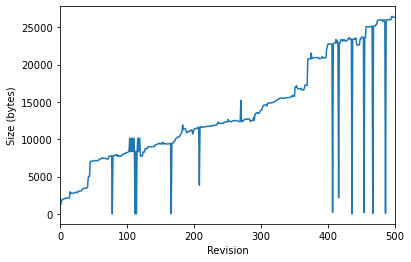

In [67]:
ax = rev_df.plot(y='size',legend=False)
ax.set_ylabel('Size (bytes)')
ax.set_xlabel('Revision')
ax.set_xlim((0,500))

Or count how many times an editor made a contribution.

In [68]:
rev_df['user'].value_counts().head()

Jiang             22
Vzbs34            15
Daniel Quinlan    14
Minesweeper       10
Kingturtle         8
Name: user, dtype: int64

There are many other parts of the very powerful Wikipedia API and scraping these APIs exposes much more metadata than parsing the HTML of these webpages, while also being easier on the servers hosting it. I will share a notebook that has functions for retrieving and parsing content, revisions, pageviews, and other information.

### In-class examples

Grace Hood's city income from Wikipedia: https://en.wikipedia.org/wiki/List_of_California_locations_by_income

In [69]:
ca_dfs = pd.read_html('https://en.wikipedia.org/wiki/List_of_California_locations_by_income')
print(len(ca_dfs))

6


In [72]:
ca_dfs[2]

,Place,County/ies[note 2],Population[1],Populationdensity[1][2][note 1],Per capita income[3],Median household income[6],Median family income[5]
0,Acalanes Ridge,Contra Costa,1226,2659.4,"$62,314","$160,000","$190,104"
1,Acampo,San Joaquin,776,827.3,"$36,756","$141,250",[7]
2,Acton,Los Angeles,6956,177.2,"$39,131","$92,245","$99,448"
3,Adelanto,San Bernardino,31773,567.3,"$9,998","$35,262","$35,537"
4,Adin,Modoc,215,62.6,"$15,452","$29,583","$60,083"
...,...,...,...,...,...,...,...
1511,Yreka,Siskiyou,7675,768.7,"$18,142","$26,385","$31,728"
1512,Yuba City,Sutter,65141,4446.8,"$23,038","$50,494","$56,734"
1513,Yucaipa,San Bernardino,52406,1845.2,"$26,103","$58,506","$69,098"
1514,Yucca Valley,San Bernardino,21083,526.9,"$20,643","$43,086","$53,767"


Get the pageview data for an article.

In [73]:
base_api = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

In [77]:
_r = base_api.format(project = 'en.wikipedia.org',
                access = 'all-access',
                agent = 'all-agents',
                article = 'Joe_Biden',
                granularity = 'daily',
                start = '20150701',
                end = '20210319'
               )
_r

'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia.org/all-access/all-agents/Joe_Biden/daily/20150701/20210319'

In [80]:
headers = {'user-agent': 'Brian Keegan research, brian.keegan@colorado.edu'}
pageviews = requests.get(_r, headers=headers).json()

<AxesSubplot:xlabel='timestamp'>

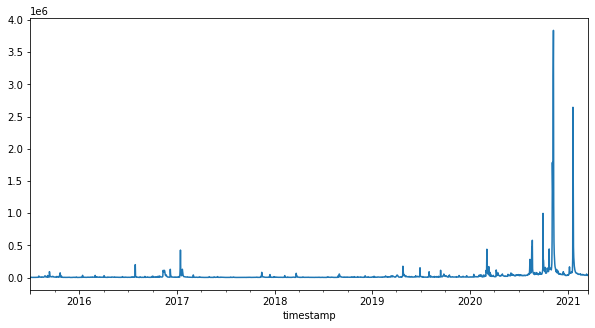

In [91]:
df = pd.DataFrame(pageviews['items'])
df['timestamp'] = pd.to_datetime(df['timestamp'],format='%Y%m%d%H')
df.set_index('timestamp')['views'].plot(figsize=(10,5))

## Scraping Reddit

Reddit also hosts a lot of detailed behavioral data that could be of interest to social scientists. As was the case with Wikipedia, our naïve inclination may be to develop scrapers and parsers to extract this information, but Reddit will give much of it to you for free through their API!

You can retrieve a few different types of entities from Reddit's API: sub-reddits, submissions, comments, and redditors. Many of these are interoperable: a sub-reddit contains submissions contributed by redditors with comments from other redditors.

We will use a wrapper library to communicate with the Reddit API called [Python Reddit API Wrapper](https://praw.readthedocs.io/en/latest/) or `praw`. 

Copy the code below to your terminal to install `praw`.

`conda install -c conda-forge praw`

Afterwards, we can import `praw`.

In [95]:
import praw

We then need to authenticate with Reddit to get access to the API. Typically you can just enter the client ID, client secret, password, username, *etc*. as strings. 

1. You will need to create an account on Reddit. After you have created an account and logged in, go to https://www.reddit.com/prefs/apps/. 
2. Scroll down and click the "create app" button at the bottom. Provide a basic name, description, and enter a URL for your homepage (or just use http://www.colorado.edu).
3. You will need the client ID (the string of characters beneath the name of your app) as well as the secret (the other string of characters) as well as your username and password.
4. You can make up a user-agent string, but include your username as good practice for the sysadmins to track you down if you break things.

![Image from Cody Buntain](http://www.cs.umd.edu/~cbuntain/inst728e/reddit_screens/1-003a.png)

You'll create an API connector object (`r`) below that will authenticate with the API and handle making the requests.

In [ ]:
r = praw.Reddit(client_id='your application id',
                client_secret='your application secret',
                password='your account password',
                user_agent='scraping script by /u/youraccountname',
                username='your account name')

You can confirm that this authentication process worked by making a simple request like printing your username.

In [97]:
print(r.user.me())

cuinfoscience


I'm going to read them in from a local file ("login.json") so that I post this notebook on the internet in the future without compromising my account security. This won't work for you, so just skip this step.

In [93]:
# Load my credentials from a local disk so I don't show the world
with open('reddit_login.json','r') as f:
    r_creds = json.load(f)

In [96]:
# Create an authenticated reddit instance using the creds
r = praw.Reddit(client_id = r_creds['client_id'],
                client_secret = r_creds['client_secret'],
                password = r_creds['password'],
                user_agent = r_creds['user_agent'],
                username = r_creds['username'])

# Make sure your reddit instance works
print(r.user.me())

Version 7.0.0 of praw is outdated. Version 7.2.0 was released Wednesday February 24, 2021.


cuinfoscience


### Sub-reddits
Now print the top 25 stories in /r/news.

[Documentation for the Subreddit model in PRAW](https://praw.readthedocs.io/en/latest/code_overview/models/subreddit.html).

Create a `news_subreddit` object to store the various attributes about this sub-reddit.

In [103]:
news_subreddit = r.subreddit('news')

The `news_subreddit` has a number of attributes and methods you can call on it. The time the sub-reddit was founded.

In [104]:
news_subreddit.created_utc

1201243765.0

That's formatted in a UNIX timecode (seconds since 1 January 1970), but we can convert it into a more readable timestamp with `datetime`'s `utcfromtimestamp`.

In [105]:
print(datetime.utcfromtimestamp(news_subreddit.created_utc))

2008-01-25 06:49:25


There are other attributes such as the number of subscribers, current active users, as well as the description of the sub-reddit.

In [107]:
news_subreddit.subscribers

22959683

In [106]:
'{0:,}'.format(news_subreddit.subscribers)

'22,959,683'

In [108]:
news_subreddit.over18

False

In [109]:
news_subreddit.active_user_count

41030

In [110]:
print(news_subreddit.description)

>* **[/r/worldnews](/r/worldnews?hl)**

>#

>* **[/r/politics](/r/politics?hl)**

>#

>* **[/r/Foodforthought](/r/Foodforthought?hl)**

>#

>* **[new comments](/r/news/comments?hl)**

> [](http://goo.gl/R6as4?ri)

> [](http://goo.gl/gBldE?ri)

> [](http://goo.gl/u5EZN?ri)

> [](http://goo.gl/exK8j?ri)

> [](http://www.reddit.com/r/news?ri)

> [](http://www.reddit.com/r/restorethefourth?ri)
                
**No analysis/opinion/politics articles.**
              
---

**No self- & meta-posts ([read the wiki rules](https://www.reddit.com/r/news/wiki/rules))**

---

**You need 10+ reddit link and comment karma to participate on /r/news, your reddit account also needs to be at least 60+ days old. This is to slow down brigading, ban evasion,spammers and trolls.**

---

See a post that violates the rules below? Had your post stuck in the spam filter? Have a question about policy? Just want to give feedback? [Send the mod team a message](http://www.reddit.com/message/compose?to=%2Fr%2Fnews).

The rules of the sub-reddit are available as a method `.rules()` which returns a list of dictionaries of rule objects.

In [111]:
news_subreddit.rules()['rules']

[{'kind': 'link',
  'description': 'A story that is over a week old, does not properly report a story, or is not noteworthy, or is not in English. Self-posts and meta-posts without moderator approval (live update threads, major breaking news, and megathreads are usually exempt) are not allowed.',
  'short_name': 'Not news',
  'violation_reason': 'Not news',
  'created_utc': 1453789451.0,
  'priority': 0,
  'description_html': '<!-- SC_OFF --><div class="md"><p>A story that is over a week old, does not properly report a story, or is not noteworthy, or is not in English. Self-posts and meta-posts without moderator approval (live update threads, major breaking news, and megathreads are usually exempt) are not allowed.</p>\n</div><!-- SC_ON -->'},
 {'kind': 'link',
  'description': 'Opinion and analysis should go in /r/Foodforthought or another relevant subreddit. This includes articles with editorial opinion, personal conjecture, or otherwise. Press releases with an editorial slant, and a

When were each of these rules created? Loop through each of the rules and print the "short_name" of the rule and the rule timestamp.

In [112]:
for rule in news_subreddit.rules()['rules']:
    created = rule['created_utc']
    print(rule['short_name'], datetime.utcfromtimestamp(created))

Not news 2016-01-26 06:24:11
Opinion/analysis or advocacy piece 2016-01-26 06:27:59
Politics 2016-01-26 06:31:33
Title not from article/editorialized title 2016-01-26 06:35:51
Paywall or is blogspam/steals content 2016-01-26 06:40:33
Covers an already-submitted story 2016-01-26 06:44:40
Racist, sexist, vitriolic, or overly crude 2016-01-26 06:47:09
Unnecessarily rude or provocative 2016-01-26 06:49:35
Cheap or distracting joke or meme 2016-01-26 06:51:12
Breaks sitewide rules, witchhunting 2016-01-26 06:56:47
Advocating or celebrating death 2021-03-02 03:19:05


We can also get a list of the moderators for this subreddit.

In [113]:
mod_list = []

for mod in news_subreddit.moderator():
    mod_list.append(mod.name)
    
mod_list

['Kylde',
 'Elderthedog',
 'ani625',
 'luster',
 'hoosakiwi',
 'DiggDejected',
 'todayilearned83',
 'gutpocketsucks',
 'ReganDryke',
 'pussgurka',
 'lanismycousin',
 'AudibleNod',
 'Bestialman',
 'Plainchant',
 'PotRoastPotato',
 'lolihull',
 'TomShoe02',
 'SulkyJoe',
 'Vfef',
 'fingerpaintswithpoop',
 'TheMightyStylus',
 'NewsModTeam',
 'RawStanky']

### Submissions

We can get a list of submissions to a sub-reddit using [a few different methods](https://praw.readthedocs.io/en/latest/code_overview/models/subreddit.html).

* `.controversial()`
* `.hot()`
* `.new()`
* `.rising()`
* `.search()`
* `.top()`

Here we will use the `.top()` method to get the top 25 submissions on the /r/news subreddit from the past 12 months.

[Documentation for the Submission model in PRAW](https://praw.readthedocs.io/en/latest/code_overview/models/submission.html).

In [114]:
top25_news = r.subreddit('news').top('year',limit=25)

In [116]:
next(top25_news)

Submission(id='jptqj9')

`top25_news` is a `ListingGenerator` object, which is a special [generator](https://www.dataquest.io/blog/python-generators-tutorial/) class defined by PRAW. It does not actually go out and get the data at this stage. There's not much you can do to look inside this `ListingGenerator` other than loop through and perform operations. In this case, lets add each submission to a list of `top25_submissions`.

In [117]:
top25_submissions = []

for submission in r.subreddit('news').top('year',limit=25):
    top25_submissions.append(submission)

We can inspect the first (top) `Submission` object.

In [118]:
first_submission = top25_submissions[0]
first_submission

Submission(id='jptqj9')

Use the `dir` function to see the other methods and attributes inside this first top `Submission` object. (There are a lot of other "hidden" attributes and methods that use the "\_" which we can ignore with this list comprehension.)

In [134]:
first_submission.gildings

{'gid_1': 1553, 'gid_2': 257, 'gid_3': 90}

In [119]:
[i for i in dir(first_submission) if '_' not in i]

['archived',
 'author',
 'awarders',
 'category',
 'clicked',
 'comments',
 'created',
 'crosspost',
 'delete',
 'distinguished',
 'domain',
 'downs',
 'downvote',
 'duplicates',
 'edit',
 'edited',
 'flair',
 'fullname',
 'gild',
 'gilded',
 'gildings',
 'hidden',
 'hide',
 'id',
 'likes',
 'locked',
 'media',
 'mod',
 'name',
 'parse',
 'permalink',
 'pinned',
 'pwls',
 'quarantine',
 'reply',
 'report',
 'save',
 'saved',
 'score',
 'selftext',
 'shortlink',
 'spoiler',
 'stickied',
 'subreddit',
 'thumbnail',
 'title',
 'unhide',
 'unsave',
 'ups',
 'upvote',
 'url',
 'visited',
 'wls']

`vars` may be even more helpful.

In [135]:
vars(first_submission)

{'_reddit': <praw.reddit.Reddit at 0x1be8476a9d0>,
 'approved_at_utc': None,
 'subreddit': Subreddit(display_name='news'),
 'selftext': '',
 'author_fullname': 't2_fkqop',
 'saved': False,
 'mod_reason_title': None,
 'gilded': 257,
 'clicked': False,
 'title': 'Joe Biden elected president of the United States',
 'link_flair_richtext': [],
 'subreddit_name_prefixed': 'r/news',
 'hidden': False,
 'pwls': 6,
 'link_flair_css_class': None,
 'downs': 0,
 'top_awarded_type': 'INACTIVE',
 'hide_score': False,
 'name': 't3_jptqj9',
 'quarantine': False,
 'link_flair_text_color': 'dark',
 'upvote_ratio': 0.87,
 'author_flair_background_color': None,
 'subreddit_type': 'public',
 'ups': 359969,
 'total_awards_received': 11087,
 'media_embed': {},
 'author_flair_template_id': None,
 'is_original_content': False,
 'user_reports': [],
 'secure_media': None,
 'is_reddit_media_domain': False,
 'is_meta': False,
 'category': None,
 'secure_media_embed': {},
 'link_flair_text': None,
 'can_mod_post': F

We can extract the features of each submission, store them in a dictionary, and save to an external list. This step will take a while (approximately one second per submission) because we make an API call for each submission in the `ListingGenerator` returned by the `r.subreddit('news').top('year',limit=25)` we're looping through.

In [136]:
submission_stats = []

for submission in r.subreddit('news').top('year',limit=25):
    d = {}
    d['id'] = submission.id
    d['title'] = submission.title
    d['num_comments'] = submission.num_comments
    d['score'] = submission.score
    d['upvote_ratio'] = submission.upvote_ratio
    d['date'] = datetime.utcfromtimestamp(submission.created_utc)
    d['domain'] = submission.domain
    d['gilded'] = submission.gilded
    d['num_crossposts'] = submission.num_crossposts
    d['nsfw'] = submission.over_18
    if submission.author is not None:
        d['author'] = submission.author.name
    submission_stats.append(d)

We can turn `submission_stats` into a pandas DataFrame.

In [137]:
top25_df = pd.DataFrame(submission_stats)
top25_df.head()

,id,title,num_comments,score,upvote_ratio,date,domain,gilded,num_crossposts,nsfw,author
0,jptqj9,Joe Biden elected president of the United States,29039,359968,0.87,2020-11-07 16:28:37,apnews.com,257,65,False,throwawaynumber53
1,j3oj21,President Donald Trump says he has tested posi...,34056,233060,0.94,2020-10-02 05:04:17,cnbc.com,230,85,False,hoosakiwi
2,l18yys,Trump has left the White House for the last ti...,11901,220071,0.80,2021-01-20 13:16:44,edition.cnn.com,67,10,False,gumball_Jones
3,jqfm3b,'Jeopardy' host Alex Trebek dies at 80 due to ...,5450,200328,0.91,2020-11-08 17:29:53,abc13.com,8,43,False,Orange_fury
4,l1d2ko,Joe Biden officially sworn in as the 46th Pres...,9272,176392,0.73,2021-01-20 16:54:00,cbsnews.com,32,9,False,douglasmacarthur


Plot out the relationship between score and number of comments.

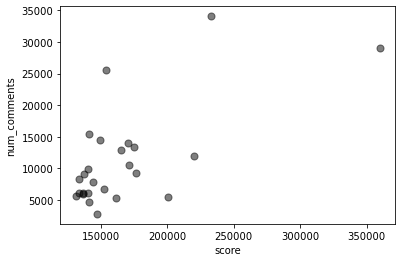

In [138]:
ax = top25_df.plot.scatter(x='score',y='num_comments',s=50,c='k',alpha=.5)
# ax.set_xlim((0,200000))
# ax.set_ylim((0,16000))

### Comments

This is a simple Reddit submission: [What is a dataset that you can't believe is available to the public?](https://www.reddit.com/r/datasets/comments/akb4mr/what_is_a_dataset_that_you_cant_believe_is/). We can inspect the comments in this simple submission.

[Documentation for Comment model in PRAW](https://praw.readthedocs.io/en/latest/code_overview/models/comment.html).

In [139]:
cant_believe = r.submission(id='akb4mr')

print("This submission was made on {0}.".format(datetime.utcfromtimestamp(cant_believe.created_utc)))
print("There are {0:,} comments.".format(cant_believe.num_comments))

This submission was made on 2019-01-27 10:59:04.
There are 27 comments.


We can inspect these comments, working from the [Comment Extraction and Parsing](https://praw.readthedocs.io/en/latest/tutorials/comments.html) tutorial in PRAW.

In [140]:
cant_believe.comments.replace_more(limit=None)

for comment in cant_believe.comments.list():
    print(comment.body)

[deleted]
First and last name of every US person who has renounced their citizenship each quarter: [https://www.federalregister.gov/quarterly-publication-of-individuals-who-have-chosen-to-expatriate](https://www.federalregister.gov/quarterly-publication-of-individuals-who-have-chosen-to-expatriate)
The SEC published "Apache log files that record and store user access statistics for the SEC.gov website" for 2003 through 2017: https://www.sec.gov/dera/data/edgar-log-file-data-set.html
[Enron email dataset](https://www.cs.cmu.edu/~./enron/) 
ICIJ Offshore Leaks Database

[https://offshoreleaks.icij.org/pages/database](https://offshoreleaks.icij.org/pages/database)

If open directories count, 'Pemiblanc' seems pretty alarming.    

[https://www.troyhunt.com/the-111-million-pemiblanc-credential-stuffing-list/](https://www.troyhunt.com/the-111-million-pemiblanc-credential-stuffing-list/)
Although not a true dataset, the Department of Energy has pretty detailed data (mostly in PDFs) showing e

Each comment has a lot of metadata we can preserve.

In [141]:
cant_believe_comment_metadata = []

for comment in cant_believe.comments.list():
    if not comment.collapsed: # Skip collapsed/deleted comments
        d = {}
        d['id'] = comment.id
        d['parent_id'] = comment.parent_id
        d['body'] = comment.body
        d['depth'] = comment.depth
        d['edited'] = comment.edited
        d['score'] = comment.score
        d['date'] = datetime.utcfromtimestamp(comment.created_utc)
        d['submission_id'] = comment.submission.id
        d['submission_title'] = comment.submission.title
        d['subreddit'] = comment.subreddit.display_name
        if comment.author is not None:
            d['author'] = comment.author.name
        cant_believe_comment_metadata.append(d)

Convert to a DataFrame.

In [142]:
cant_believe_df = pd.DataFrame(cant_believe_comment_metadata)

# How long is the comment
cant_believe_df['comment_length'] = cant_believe_df['body'].str.len()

cant_believe_df.head()

,id,parent_id,body,depth,edited,score,date,submission_id,submission_title,subreddit,author,comment_length
0,ef3cp0s,t3_akb4mr,First and last name of every US person who has...,0,False,93,2019-01-27 11:52:02,akb4mr,What is a dataset that you can’t believe is av...,datasets,hamiltonkg,289
1,ef4iy3r,t3_akb4mr,"The SEC published ""Apache log files that recor...",0,1548625113.0,21,2019-01-27 21:35:25,akb4mr,What is a dataset that you can’t believe is av...,datasets,brianckeegan,187
2,ef4fe4q,t3_akb4mr,[Enron email dataset](https://www.cs.cmu.edu/~...,0,False,22,2019-01-27 20:42:16,akb4mr,What is a dataset that you can’t believe is av...,datasets,mouse_Brains,56
3,ef4ykjj,t3_akb4mr,ICIJ Offshore Leaks Database\n\n[https://offsh...,0,1548638381.0,6,2019-01-28 00:58:37,akb4mr,What is a dataset that you can’t believe is av...,datasets,emican,349
4,ef5h6gw,t3_akb4mr,"Although not a true dataset, the Department of...",0,False,6,2019-01-28 04:48:54,akb4mr,What is a dataset that you can’t believe is av...,datasets,soil_nerd,350


Do comments deeper in this comment tree have lower scores?

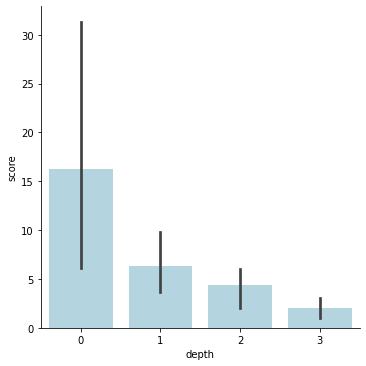

In [143]:
sb.catplot(x='depth',y='score',data=cant_believe_df,kind='bar',color='lightblue')

Do comments deeper in this comment tree have shorter lengths?

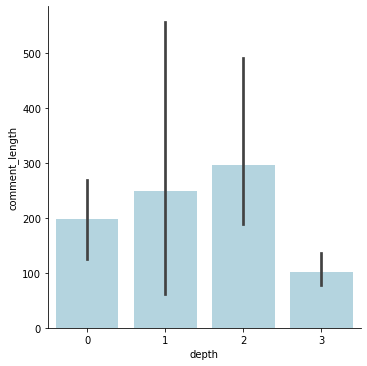

In [144]:
sb.catplot(x='depth',y='comment_length',data=cant_believe_df,kind='bar',color='lightblue')

### Redditors

A Redditor is a user and we can get meta-data about the account as well as the history of the user's comments and submissions from the API.

[Documentation for the Redditor model in PRAW](https://praw.readthedocs.io/en/latest/code_overview/models/redditor.html).

How much link and comment karma does this user have?

In [152]:
spez = r.redditor('spez')
print("Link karma: {0:,}".format(spez.link_karma))
print("Comment karma: {0:,}".format(spez.comment_karma))

Link karma: 145,162
Comment karma: 747,868


Interestingly, Reddit flags the users who are employees of Reddit as well as if accounts have verified email addresses.

In [149]:
spez.is_employee

False

In [150]:
spez.has_verified_email

True

We can also get the time this user's account was created.

In [151]:
datetime.utcfromtimestamp(spez.created_utc)

datetime.datetime(2014, 4, 7, 19, 13, 46)

We can also get information about individual redditors' submissions and comment histories. Here we will use u/spez (the CEO of Reddit), get his top-voted submissions, and loop through them to get the data for each submission.

In [153]:
spez_submissions = []

for submission in r.redditor('spez').submissions.top('all',limit=25):
    d = {}
    d['id'] = submission.id
    d['title'] = submission.title
    d['num_comments'] = submission.num_comments
    d['score'] = submission.score
    d['upvote_ratio'] = submission.upvote_ratio
    d['date'] = datetime.utcfromtimestamp(submission.created_utc)
    d['domain'] = submission.domain
    d['gilded'] = submission.gilded
    d['num_crossposts'] = submission.num_crossposts
    d['nsfw'] = submission.over_18
    if comment.author is not None:
        d['author'] = submission.author.name
    spez_submissions.append(d)

Again we can turn this list of dictionaries into a DataFrame to do substantive data analysis.

In [154]:
pd.DataFrame(spez_submissions).head()

,id,title,num_comments,score,upvote_ratio,date,domain,gilded,num_crossposts,nsfw,author
0,7jsyqt,"The FCC’s vote was predictably frustrating, bu...",14641,194097,0.86,2017-12-14 17:10:15,self.announcements,7,25,False,spez
1,7fx1x4,An update on the fight for the free and open i...,7763,92809,0.81,2017-11-27 18:03:30,self.blog,4,18,False,spez
2,5frg1n,TIFU by editing some comments and creating an ...,35337,50314,0.61,2016-11-30 19:04:49,self.announcements,32,0,False,spez
3,3cxedn,"I am Steve Huffman, the new CEO of reddit. AMA.",12728,41374,0.83,2015-07-11 17:02:59,self.IAmA,2,0,False,spez
4,gxas21,"Upcoming changes to our content policy, our bo...",41440,40926,0.55,2020-06-05 19:04:47,self.announcements,19,84,False,spez


We can also get all the comments made by an editor.

In [155]:
spez_comments = []

for comment in r.redditor('spez').comments.top('all',limit=25):
    d = {}
    d['id'] = comment.id
    d['body'] = comment.body
    try:
        d['depth'] = comment.depth
    except:
        d['depth'] = np.nan
    d['edited'] = comment.edited
    d['score'] = comment.score
    d['date'] = datetime.utcfromtimestamp(comment.created_utc)
    d['submission_id'] = comment.submission.id
    d['submission_title'] = comment.submission.title
    d['subreddit'] = comment.subreddit.display_name
    if comment.author is not None:
        d['author'] = comment.author.name
    spez_comments.append(d)

KeyboardInterrupt: 

In [156]:
pd.DataFrame(spez_comments).head()

,id,body,depth,edited,score,date,submission_id,submission_title,subreddit,author
0,d992fwq,Reddit search might work by then.,NaN,False,22207,2016-10-26 21:07:22,59k22p,"Hey, it’s Reddit’s totally politically neutral...",announcements,spez


This user's top comments are mostly focused in the /r/announcements subreddit.

In [ ]:
pd.DataFrame(spez_comments)['subreddit'].value_counts()